<a href="https://colab.research.google.com/github/vippatil1604/air_quality_index_forecasting/blob/main/ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://apache.mirror.amaze.com.au/spark/spark-3.0.2/spark-3.0.2-bin-hadoop3.2.tgz
!tar xf spark-3.0.2-bin-hadoop3.2.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "spark-3.0.2-bin-hadoop3.2"

In [3]:
import findspark
findspark.init()

In [4]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [5]:
!pip install pmdarima

     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 9.5MB 18.7MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
import pyspark.sql
from pyspark.sql import Row
from pyspark.sql.types import *
import csv
import pandas as pd

#from statsmodels.tsa.stattools import adfuller

In [50]:
l1 = []
for i in range(2016,2021):
  aqi_df = pd.read_csv("/content/drive/MyDrive/Project/Data/daily_aqi_by_county_{}.csv".format(str(i)))
  l1.append(aqi_df)

l2 = pd.concat(l1)

In [51]:
l2.shape
Cali_PD = l2.loc[l2['county Name'] == "Alameda"]
Cali_PD.shape

(1676, 10)

In [ ]:
state_df = aqi_df.filter(aqi_df['State Name'] == "California")
state_df = aqi_df.filter(aqi_df['county Name'] == "Alameda")
state_df.take(10)

[Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='2019-01-01', AQI='34', Category='Good', Defining Parameter='NO2', Defining Site='06-001-0013', Number of Sites Reporting='7'),
 Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='2019-01-02', AQI='50', Category='Good', Defining Parameter='PM2.5', Defining Site='06-001-0007', Number of Sites Reporting='7'),
 Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='2019-01-03', AQI='71', Category='Moderate', Defining Parameter='PM2.5', Defining Site='06-001-0013', Number of Sites Reporting='7'),
 Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='2019-01-04', AQI='87', Category='Moderate', Defining Parameter='PM2.5', Defining Site='06-001-0015', Number of Sites Reporting='7'),
 Row(State Name='California', county Name='Alameda', State Code='06', County Code='001', Date='201

In [ ]:
California_df = state_df.select('State Name', 'State Code', 'county Name', 'County Code', 'Date', 'AQI', 'Category')
California_df.take(10)

[Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2019-01-01', AQI='34', Category='Good'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2019-01-02', AQI='50', Category='Good'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2019-01-03', AQI='71', Category='Moderate'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2019-01-04', AQI='87', Category='Moderate'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2019-01-05', AQI='53', Category='Moderate'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2019-01-06', AQI='31', Category='Good'),
 Row(State Name='California', State Code='06', county Name='Alameda', County Code='001', Date='2019-01-07', AQI='38', Category='Good'),
 Row(State Name='California', State 

In [ ]:
California_df.toPandas().to_csv('/content/drive/MyDrive/Project/Data/aqi_dataset_3.csv', index=False, header=True)

# ARIMA start

In [ ]:
California_df = spark.read.csv("/content/drive/MyDrive/Project/Data/aqi_dataset_3.csv", header =True, inferSchema=True)
California_df.printSchema()


root
 |-- State Name: string (nullable = true)
 |-- State Code: integer (nullable = true)
 |-- county Name: string (nullable = true)
 |-- County Code: integer (nullable = true)
 |-- Date: string (nullable = true)
 |-- AQI: integer (nullable = true)
 |-- Category: string (nullable = true)



In [ ]:
import pandas as pd
import numpy as np 

In [ ]:
##showing label statistics

California_df.describe("AQI").show()

+-------+------------------+
|summary|               AQI|
+-------+------------------+
|  count|               365|
|   mean| 45.93150684931507|
| stddev|16.963866550039917|
|    min|                22|
|    max|               150|
+-------+------------------+



In [ ]:
#Cali_PD = California_df.toPandas()


In [ ]:
Cali_PD

,State Name,county Name,State Code,County Code,Date,AQI,Category,Defining Parameter,Defining Site,Number of Sites Reporting
12500,California,Alameda,06,1,2000-01-01,55,Moderate,PM2.5,06-001-0007,4
12501,California,Alameda,06,1,2000-01-02,38,Good,NO2,06-001-1001,4
12502,California,Alameda,06,1,2000-01-03,42,Good,NO2,06-001-0003,4
12503,California,Alameda,06,1,2000-01-04,59,Moderate,PM2.5,06-001-1001,4
12504,California,Alameda,06,1,2000-01-05,35,Good,NO2,06-001-0003,4
...,...,...,...,...,...,...,...,...,...,...
9618,California,Alameda,6,1,2020-08-28,97,Moderate,PM2.5,06-001-0015,7
9619,California,Alameda,6,1,2020-08-29,79,Moderate,PM2.5,06-001-0007,7
9620,California,Alameda,6,1,2020-08-30,67,Moderate,PM2.5,06-001-0007,7
9621,California,Alameda,6,1,2020-08-31,73,Moderate,PM2.5,06-001-0013,7


In [43]:
# Prepare training and test data.
#test = Cali_PD.randomSplit([0.7, 0.3], seed=42)
train=Cali_PD.sample(frac=0.7,random_state=200) #random state is a seed value
test=Cali_PD.drop(train.index)

In [ ]:
train.count()


State Name                   5264
county Name                  5264
State Code                   5264
County Code                  5264
Date                         5264
AQI                          5264
Category                     5264
Defining Parameter           5264
Defining Site                5264
Number of Sites Reporting    5264
dtype: int64

In [ ]:
test.count()

State Name                   456
county Name                  456
State Code                   456
County Code                  456
Date                         456
AQI                          456
Category                     456
Defining Parameter           456
Defining Site                456
Number of Sites Reporting    456
dtype: int64

In [ ]:
train_array = train["AQI"]
print(train_array.shape)

test_array = test["AQI"]
print(test_array.shape) 

(5264,)
(456,)


In [ ]:
from statsmodels.tsa.stattools import adfuller

print("p-value:", adfuller(train_array.dropna())[1])

p-value: 0.0


In [ ]:
import pandas.testing as tm

In [ ]:
import pmdarima as pmd

def arimamodel(timeseriesarray):
    autoarima_model = pmd.auto_arima(timeseriesarray, 
                              start_p=0, 
                              start_q=0,
                              test="adf",
                              trace=True)
    return autoarima_model

In [ ]:
arima_model = arimamodel(train_array)
arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=47358.932, Time=0.17 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=47360.890, Time=0.27 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=47360.895, Time=0.47 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=56925.051, Time=0.10 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=47362.885, Time=0.81 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.845 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 5264
Model:                        SARIMAX   Log Likelihood              -23677.466
Date:                Wed, 21 Apr 2021   AIC                          47358.932
Time:                        02:39:44   BIC                          47372.070
Sample:                             0   HQIC                         47363.525
                               - 5264                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     49.3666      0.452    109.228      0.000      48.481      50.252
sigma2       472.5392      5.959     79.302      0.000     460.860     484.218
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):             22619.05
Prob(Q):                              0.84   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             2.47
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
data

,State Name,State Code,county Name,County Code,AQI,Category
Date,,,,,,
2019-01-01,California,6,Alameda,1,34,Good
2019-01-02,California,6,Alameda,1,50,Good
2019-01-03,California,6,Alameda,1,71,Moderate
2019-01-04,California,6,Alameda,1,87,Moderate
2019-01-05,California,6,Alameda,1,53,Moderate
...,...,...,...,...,...,...
2019-12-27,California,6,Alameda,1,39,Good
2019-12-28,California,6,Alameda,1,42,Good
2019-12-29,California,6,Alameda,1,36,Good


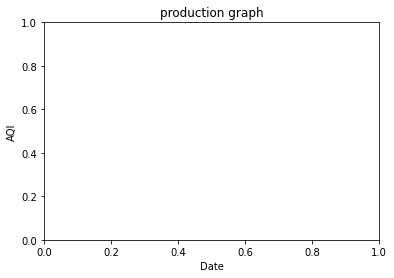

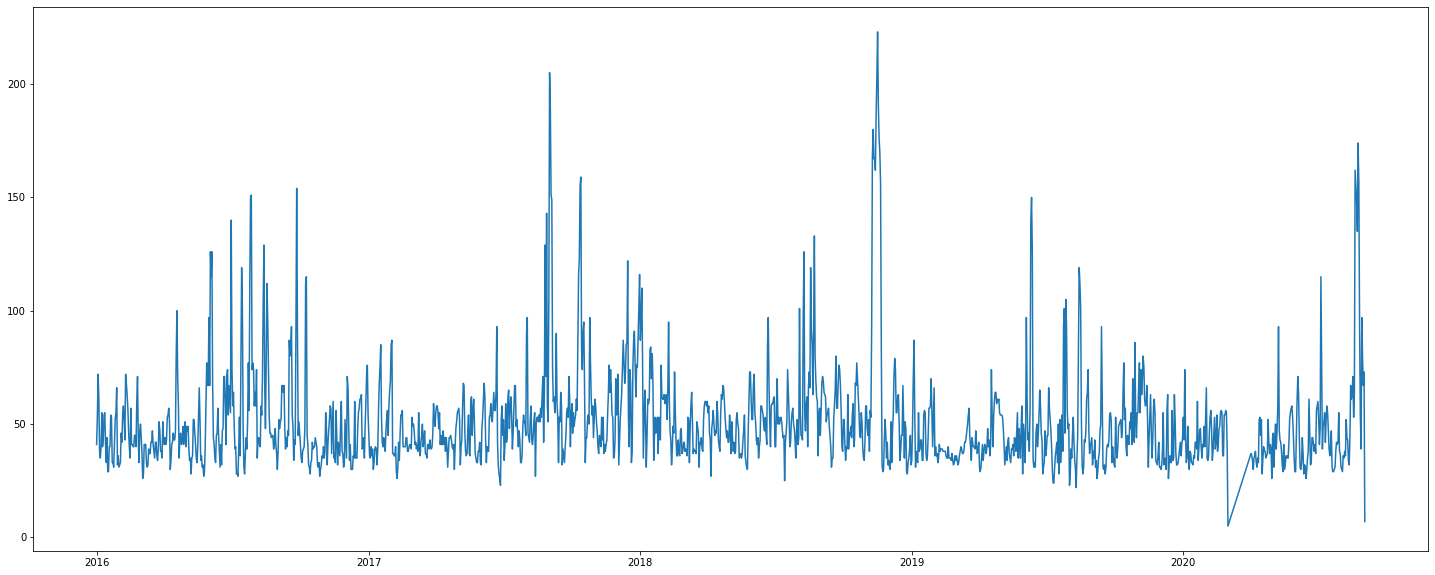

In [52]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

series = Cali_PD[["Date","AQI"]]
series.columns=['Date', 'AQI']
series=series.dropna()
series['Date'] = pd.to_datetime(series['Date'])
series.head()series.set_index('Date', inplace=True) #set date as index


plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("production graph")
plt.figure(figsize=(25, 10))

plt.plot(series)


In [ ]:
series

,AQI
Date,
2000-01-01,55
2000-01-02,38
2000-01-03,42
2000-01-04,59
2000-01-05,35
...,...
2020-08-28,97
2020-08-29,79
2020-08-30,67


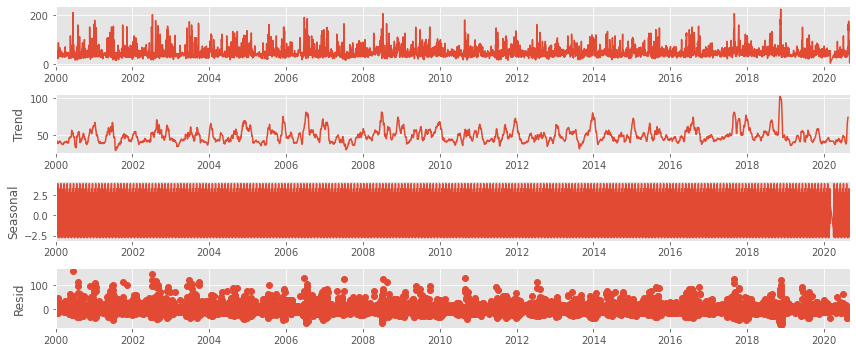

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
#result = seasonal_decompose(series, model='multiplicative')
#result.plot()
#plt.show()

result = seasonal_decompose(series, period = 30)

from pylab import rcParams
rcParams['figure.figsize'] = 12,5
result.plot();

ConversionError: ignored

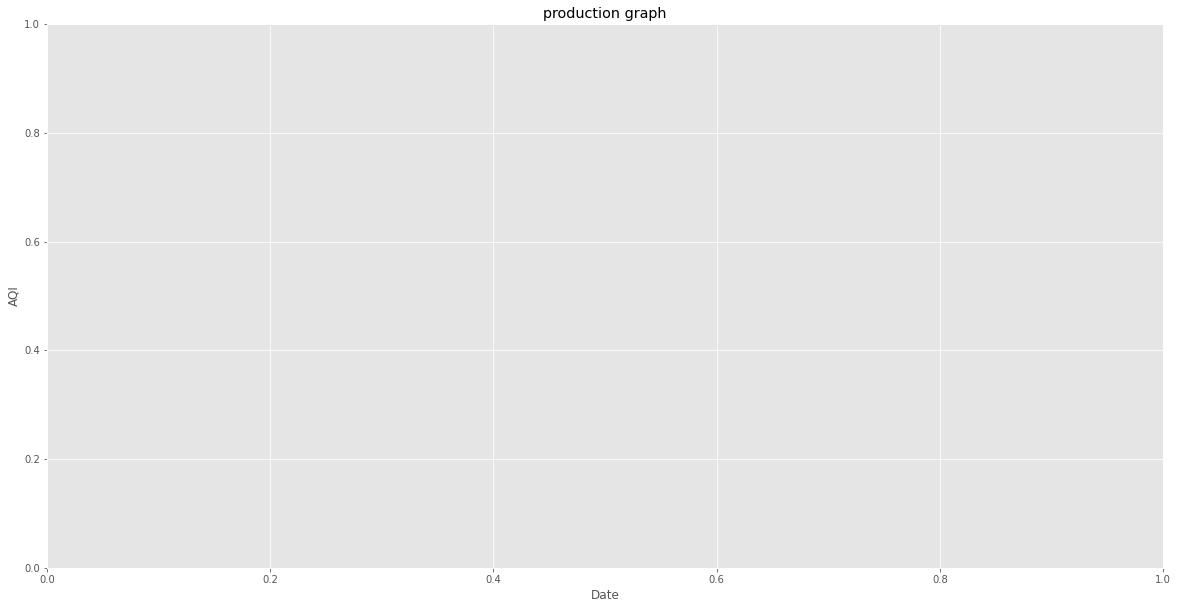

In [ ]:
series = Cali_PD[["AQI","Date"]]
#series.plot()
#plt.ylim((0,250))

#plt.show()

plt.xlabel("Date")
plt.ylabel("AQI")
plt.title("production graph")
plt.plot(series)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
#from import automodel
test['ARIMA'] = arima_model.predict(len(test))

test.head(5)

,State Name,State Code,county Name,County Code,Date,AQI,Category,ARIMA
0,California,6,Alameda,1,2019-01-01,34,Good,45.631373
1,California,6,Alameda,1,2019-01-02,50,Good,45.631373
3,California,6,Alameda,1,2019-01-04,87,Moderate,45.631373
6,California,6,Alameda,1,2019-01-07,38,Good,45.631373
7,California,6,Alameda,1,2019-01-08,34,Good,45.631373


In [ ]:
Cali_PD

,State Name,State Code,county Name,County Code,AQI,Category
Date,,,,,,
2019-01-01,California,6,Alameda,1,34,Good
2019-01-02,California,6,Alameda,1,50,Good
2019-01-03,California,6,Alameda,1,71,Moderate
2019-01-04,California,6,Alameda,1,87,Moderate
2019-01-05,California,6,Alameda,1,53,Moderate
...,...,...,...,...,...,...
2019-12-27,California,6,Alameda,1,39,Good
2019-12-28,California,6,Alameda,1,42,Good
2019-12-29,California,6,Alameda,1,36,Good


In [ ]:
#Cali_PD.set_index('Date', inplace=True, drop=False)

cali_updated = Cali_PD[["Date","AQI"]]
cali_updated = cali_updated.rename(columns={"Date": "ds", "AQI": "y"})
import pandas as pd
from fbprophet import Prophet

# instantiate the model and set parameters
model = Prophet(
    interval_width=0.95,
    growth='linear',
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    seasonality_mode='additive'
)

# fit the model to historical data
model.fit(cali_updated)

future_pd = model.make_future_dataframe(
    periods=0,
    freq='d',
    include_history=True
)

# predict over the dataset
forecast_pd = model.predict(future_pd)


In [ ]:
for index, row in forecast_pd.iterrows():
  if row["yhat"] < 0:
    print(row["yhat"],row["ds"])

In [ ]:
forecast_pd

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-01-01,37.842677,21.204614,79.685837,37.842677,37.842677,12.495083,12.495083,12.495083,15.451534,15.451534,15.451534,0.208504,0.208504,0.208504,-3.164955,-3.164955,-3.164955,0.0,0.0,0.0,50.337760
1,2019-01-02,37.802004,20.364536,80.394849,37.802004,37.802004,13.052622,13.052622,13.052622,15.451534,15.451534,15.451534,1.487468,1.487468,1.487468,-3.886380,-3.886380,-3.886380,0.0,0.0,0.0,50.854626
2,2019-01-03,37.761330,17.779532,75.692000,37.761330,37.761330,10.779270,10.779270,10.779270,15.451534,15.451534,15.451534,-0.090775,-0.090775,-0.090775,-4.581489,-4.581489,-4.581489,0.0,0.0,0.0,48.540600
3,2019-01-04,37.720657,19.368133,76.509741,37.720657,37.720657,10.737004,10.737004,10.737004,15.451534,15.451534,15.451534,0.523582,0.523582,0.523582,-5.238112,-5.238112,-5.238112,0.0,0.0,0.0,48.457661
4,2019-01-05,37.679984,18.619724,78.324971,37.679984,37.679984,10.205728,10.205728,10.205728,15.451534,15.451534,15.451534,0.599382,0.599382,0.599382,-5.845188,-5.845188,-5.845188,0.0,0.0,0.0,47.885713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,2019-12-27,23.259079,12.219769,70.636026,23.259079,23.259079,16.497119,16.497119,16.497119,15.451534,15.451534,15.451534,0.523582,0.523582,0.523582,0.522003,0.522003,0.522003,0.0,0.0,0.0,39.756198
361,2019-12-28,23.218600,10.215973,66.026460,23.218600,23.218600,15.934636,15.934636,15.934636,15.451534,15.451534,15.451534,0.599382,0.599382,0.599382,-0.116281,-0.116281,-0.116281,0.0,0.0,0.0,39.153236
362,2019-12-29,23.178122,5.567676,64.933026,23.178122,23.178122,12.538467,12.538467,12.538467,15.451534,15.451534,15.451534,-2.113704,-2.113704,-2.113704,-0.799363,-0.799363,-0.799363,0.0,0.0,0.0,35.716588
363,2019-12-30,23.137643,6.818008,65.214002,23.137643,23.137643,13.323191,13.323191,13.323191,15.451534,15.451534,15.451534,-0.614457,-0.614457,-0.614457,-1.513886,-1.513886,-1.513886,0.0,0.0,0.0,36.460834


In [ ]:
# calculate MAE between expected and predicted values for december

from sklearn.metrics import mean_absolute_error
y_true = cali_updated['y'].values
y_pred = forecast_pd['yhat'].values
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)

MAE: 9.715


In [ ]:
y_true.shape

(19063,)

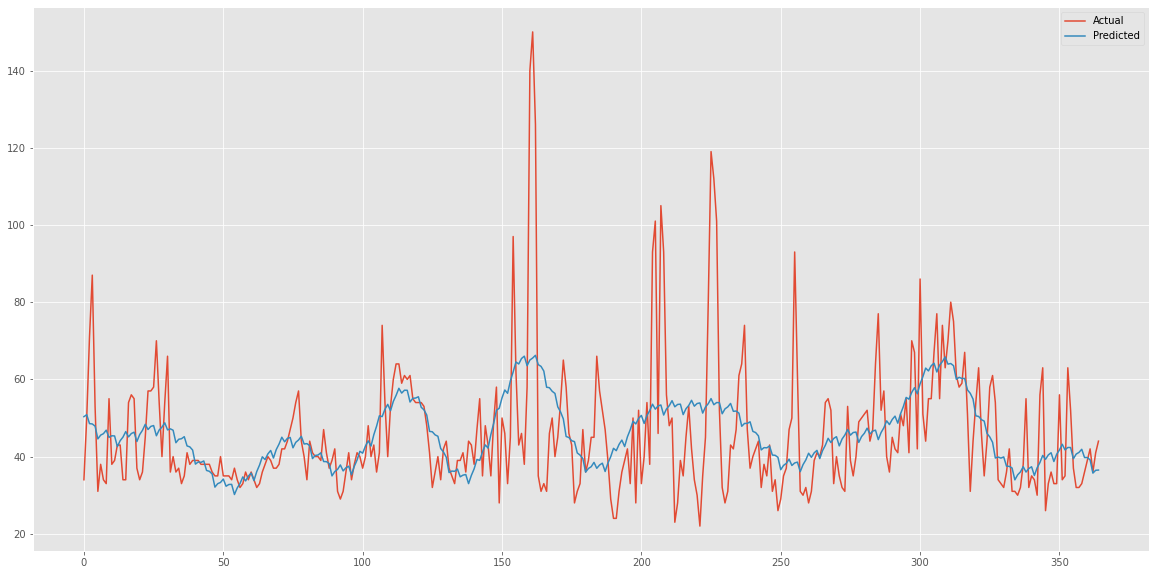

In [ ]:
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [ ]:
California_df.count()

19063

In [ ]:
forecast_pd.tail(n=25)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
705,2020-12-06,72.349910,-30.239653,188.528476,21.075349,125.988723,10.195270,10.195270,10.195270,22.339181,22.339181,22.339181,-1.517009,-1.517009,-1.517009,-10.626902,-10.626902,-10.626902,0.0,0.0,0.0,82.545180
706,2020-12-07,72.475582,-28.942747,201.313066,20.960263,126.347367,11.648476,11.648476,11.648476,22.339181,22.339181,22.339181,-0.247148,-0.247148,-0.247148,-10.443558,-10.443558,-10.443558,0.0,0.0,0.0,84.124058
707,2020-12-08,72.601254,-32.028350,205.537851,20.845178,126.700428,13.626099,13.626099,13.626099,22.339181,22.339181,22.339181,1.458766,1.458766,1.458766,-10.171849,-10.171849,-10.171849,0.0,0.0,0.0,86.227353
708,2020-12-09,72.726926,-35.841483,208.931308,20.730040,127.007088,14.811645,14.811645,14.811645,22.339181,22.339181,22.339181,2.299725,2.299725,2.299725,-9.827261,-9.827261,-9.827261,0.0,0.0,0.0,87.538571
709,2020-12-10,72.852598,-33.743147,202.906537,20.614722,127.313749,11.486151,11.486151,11.486151,22.339181,22.339181,22.339181,-1.426485,-1.426485,-1.426485,-9.426545,-9.426545,-9.426545,0.0,0.0,0.0,84.338749
710,2020-12-11,72.978270,-27.266077,187.082930,20.499403,127.620409,12.255776,12.255776,12.255776,22.339181,22.339181,22.339181,-1.096090,-1.096090,-1.096090,-8.987315,-8.987315,-8.987315,0.0,0.0,0.0,85.234046
711,2020-12-12,73.103941,-33.202282,209.813009,20.384085,127.927069,14.339791,14.339791,14.339791,22.339181,22.339181,22.339181,0.528241,0.528241,0.528241,-8.527632,-8.527632,-8.527632,0.0,0.0,0.0,87.443732
712,2020-12-13,73.229613,-36.569443,205.690968,20.272078,128.233729,12.756599,12.756599,12.756599,22.339181,22.339181,22.339181,-1.517009,-1.517009,-1.517009,-8.065573,-8.065573,-8.065573,0.0,0.0,0.0,85.986212
713,2020-12-14,73.355285,-28.134680,197.718432,20.161219,128.540389,14.473217,14.473217,14.473217,22.339181,22.339181,22.339181,-0.247148,-0.247148,-0.247148,-7.618816,-7.618816,-7.618816,0.0,0.0,0.0,87.828502
714,2020-12-15,73.480957,-23.359171,205.128884,20.050359,128.847049,16.593718,16.593718,16.593718,22.339181,22.339181,22.339181,1.458766,1.458766,1.458766,-7.204229,-7.204229,-7.204229,0.0,0.0,0.0,90.074675


In [ ]:
California_df.createOrReplaceTempView("California_table")
df_sql = spark.sql("SELECT Date,AQI FROM California_table")
df_sql.show()

+----------+---+
|      Date|AQI|
+----------+---+
|2018-01-01| 87|
|2018-01-02| 95|
|2018-01-03|110|
|2018-01-04| 79|
|2018-01-05| 35|
|2018-01-06| 51|
|2018-01-07| 65|
|2018-01-08| 52|
|2018-01-09| 31|
|2018-01-10| 44|
|2018-01-11| 61|
|2018-01-12| 59|
|2018-01-13| 61|
|2018-01-14| 83|
|2018-01-15| 84|
|2018-01-16| 70|
|2018-01-17| 81|
|2018-01-18| 67|
|2018-01-19| 34|
|2018-01-20| 45|
+----------+---+
only showing top 20 rows



In [ ]:
def loadData(sparkSession):
    California_df.createOrReplaceTempView("opp")
    return spark.sql("SELECT DATE_FORMAT(Date,'yyyy-MM-dd') as Date, AQI FROM opp GROUP BY DATE_FORMAT(Date,'yyyy-MM-dd) ORDER BY Date")
 
def saveData(result):
    result.show()

In [ ]:
def predict_ARIMA_Spark(value, period):
    spark_context = pyspark.SparkContext.getOrCreate()
    model = spark_context._jvm.com.cloudera.sparkts.models.ARIMA.autoFit(_py2java(spark_context, Vectors.dense(value)), MAX_P, MAX_D, MAX_Q)
    p = _java2py(spark_context, model.p())
    d = _java2py(spark_context, model.d())
    q = _java2py(spark_context, model.q())
    jts = _py2java(spark_context, Vectors.dense(value))
    aic = model.approxAIC(jts)
    print ("ARIMA(p, d, q)", "AIC=", aic)
    jfore = model.forecast(jts, period)
    return _java2py(spark_context, jfore)[len(value):]

In [ ]:
import statsmodels.tsa.api as sm
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_sql, order=(5,1,0))

ModuleNotFoundError: ignored

# SARIMAX start

In [121]:
# Prepare training and test data.
#test = Cali_PD.randomSplit([0.7, 0.3], seed=42)
train=series.sample(frac=0.7,random_state=200) #random state is a seed value
test=series.drop(train.index)

In [122]:
train

,AQI
Date,
2016-10-01,41
2019-07-28,93
2020-04-04,30
2020-06-06,31
2020-08-25,93
...,...
2017-12-22,75
2016-09-24,41
2020-07-06,39


In [81]:
y = train['AQI'].resample('MS').mean()

# The term bfill means that we use the value before filling in missing values
y = y.fillna(y.bfill())

print(y)
 

Date
2016-01-01     42.739130
2016-02-01     47.320000
2016-03-01     37.909091
2016-04-01     51.000000
2016-05-01     45.000000
2016-06-01     61.125000
2016-07-01     62.850000
2016-08-01     54.304348
2016-09-01     59.791667
2016-10-01     35.304348
2016-11-01     43.956522
2016-12-01     45.720000
2017-01-01     46.500000
2017-02-01     42.600000
2017-03-01     43.440000
2017-04-01     43.050000
2017-05-01     47.916667
2017-06-01     50.952381
2017-07-01     48.176471
2017-08-01     63.181818
2017-09-01     70.500000
2017-10-01     70.571429
2017-11-01     48.900000
2017-12-01     69.333333
2018-01-01     59.238095
2018-02-01     52.000000
2018-03-01     44.157895
2018-04-01     49.950000
2018-05-01     44.760000
2018-06-01     54.818182
2018-07-01     48.631579
2018-08-01     66.368421
2018-09-01     56.461538
2018-10-01     51.608696
2018-11-01    101.705882
2018-12-01     46.043478
2019-01-01     50.666667
2019-02-01     35.875000
2019-03-01     40.250000
2019-04-01     47.14

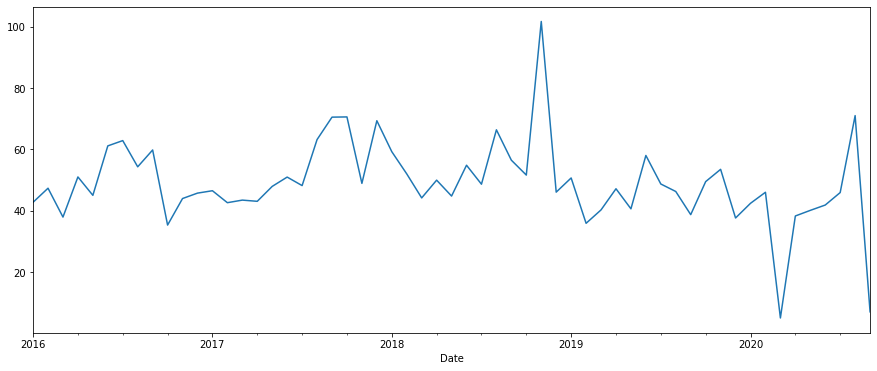

In [82]:
y.plot(figsize=(15, 6))
plt.show()

In [83]:
import itertools
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [84]:
import warnings
import statsmodels.api as sm


warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:601.4183032965485
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:445.48189770255334
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:379.04674398515596
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:1172.7128647511645
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:385.7773893113332
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:373.21006570845515
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:284.7070774917486
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:1418.0407349169766
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:546.4743765717982
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:419.0069418923504
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:373.35182031012465
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:1387.689450872808
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:387.72970387703424
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:367.9304074630415
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:286.5562009847953
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:1390.8244985124893
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:475.9029087866856
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:381.67425541037085
A

In [87]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])
 


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6296         -0        inf      0.000      -0.630      -0.630
ar.S.L12      -2.2293   5.51e-26  -4.04e+25      0.000      -2.229      -2.229
ma.S.L12   -7.398e+12   8.74e-32  -8.47e+43      0.000    -7.4e+12    -7.4e+12
sigma2      1.547e-16   3.41e-10   4.54e-07      1.000   -6.68e-10    6.68e-10


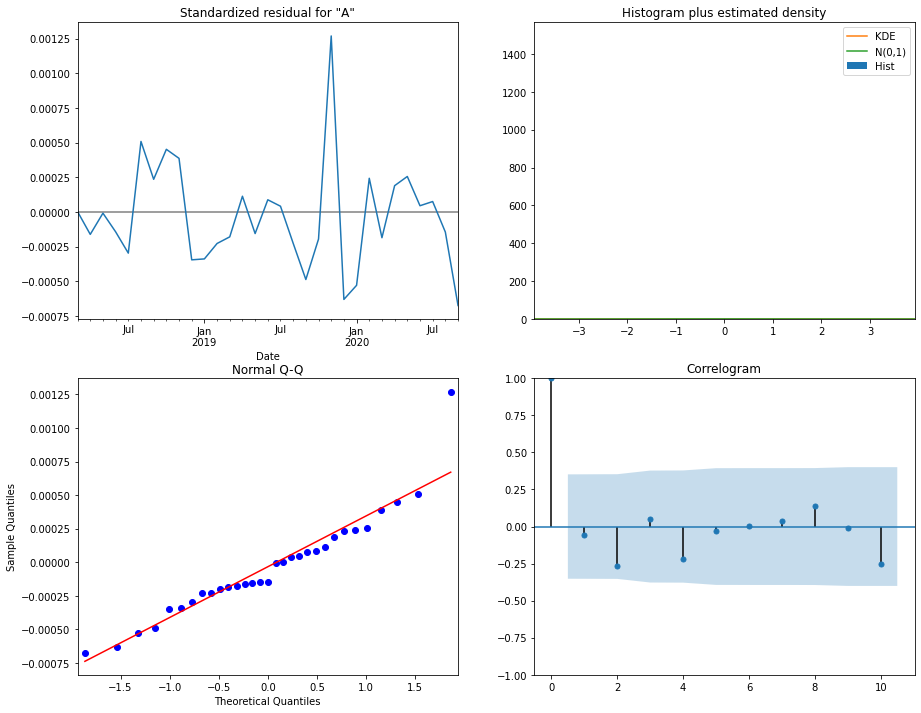

In [88]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()
 

In [93]:
#test data prediction
steps=len(test-1)
predictions= results.predict(start =len(train), end=(len(train)+len(test)+(steps)),exog=test)

In [97]:
print(predictions)

2113-10-01    3.038432e+33
2113-11-01   -1.060408e+34
2113-12-01    1.957754e+33
2114-01-01    3.346517e+33
2114-02-01    9.290840e+33
                  ...     
2197-04-01   -1.959390e+62
2197-05-01   -4.563932e+62
2197-06-01    1.023470e+61
2197-07-01   -3.859516e+62
2197-08-01   -1.184141e+63
Freq: MS, Name: predicted_mean, Length: 1007, dtype: float64


In [98]:
import math
y_forecasted = predictions.predicted_mean
y_truth = test['Date']

# Compute the mean square error
rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

AttributeError: ignored

In [94]:
forecast_1= results.forecast(steps=steps, exog=test)

In [96]:
act= pd.DataFrame(scaler_output.iloc[train:, 0])

NameError: ignored

In [ ]:
predictions=pd.DataFrame(predictions)
predictions.reset_index(drop=True, inplace=True)
predictions.index=test_X.index
predictions['Actual'] = act['Stock Price next day']
predictions.rename(columns={0:'Pred'}, inplace=True)

In [100]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'), dynamic=False)
print(pred.predicted_mean)
pred_ci = pred.conf_int()

Date
2016-01-01      0.000000
2016-02-01     33.770134
2016-03-01     48.203552
2016-04-01     40.916189
2016-05-01     45.620766
2016-06-01     48.601152
2016-07-01     54.528698
2016-08-01     64.126347
2016-09-01     56.895999
2016-10-01     57.159106
2016-11-01     44.516294
2016-12-01     38.350516
2017-01-01     48.997710
2017-02-01     49.872015
2017-03-01     52.151465
2017-04-01     38.976440
2017-05-01     48.790448
2017-06-01     47.981537
2017-07-01     49.032037
2017-08-01     54.870672
2017-09-01     44.920510
2017-10-01     66.037948
2017-11-01     66.557736
2017-12-01     61.887550
2018-01-01    118.399358
2018-02-01    117.717055
2018-03-01     43.992043
2018-04-01     64.899711
2018-05-01     45.619876
2018-06-01     68.055663
2018-07-01     76.025491
2018-08-01     19.599208
2018-09-01     34.832180
2018-10-01     10.059223
2018-11-01     66.169743
2018-12-01     77.894350
2019-01-01     81.896635
2019-02-01     56.867089
2019-03-01     56.828167
2019-04-01     36.75

In [66]:
pred_future = results.get_prediction(start=pd.to_datetime('2021-01-01'), dynamic=False)
pred_ci_future = pred_future.conf_int()
pred_future.prediction_results

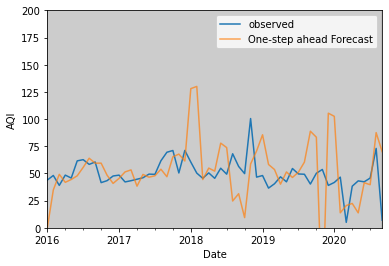

In [68]:
ax = y['2016':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('AQI')
plt.ylim(0,200)
plt.legend()

plt.show()

In [ ]:
import math
y_forecasted = pred.predicted_mean
y_truth = y['2000-01-01':]

# Compute the mean square error
rmse = math.sqrt(((y_forecasted - y_truth) ** 2).mean())
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 10.03


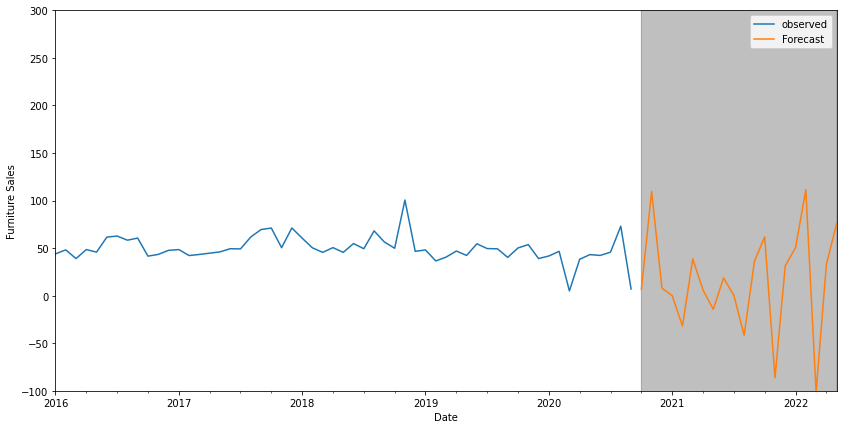

In [79]:
pred_uc = results.get_forecast(steps=20)
pred_ci = pred_uc.conf_int()
ax = y.plot(label='observed', figsize=(14, 7))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Furniture Sales')
plt.ylim(-100,300)
plt.legend()
plt.show()

# test prediction for sarimax

In [114]:
def get_sarima_params(data):
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 24) for x in list(itertools.product(p, d, q))]
  result_table = pd.DataFrame(columns=['pda','seasonal_pda','aic'])

  for param in pdq:
      for param_seasonal in seasonal_pdq:
          try:
            mod = sm.tsa.statespace.SARIMAX(data,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            result_table = result_table.append({'pda':param, 'seasonal_pda':param_seasonal, 'aic':results.aic},ignore_index=True)
          except:
            continue

  optimal_params = result_table[result_table['aic']==result_table.aic.min()]
  order = optimal_params.pda.values[0]
  seasonal_order = optimal_params.seasonal_pda.values[0]
  return (order,seasonal_order)

In [115]:
def apply_sarimax(train_data,train_exog, test_data, test_exog , order , seasonal_order):
  print('SARIMAX MODEL ORDERS ARE = {} {} '.format(order,seasonal_order))
   
  mod = sm.tsa.statespace.SARIMAX(train_data,exog=train_exog,order=order,seasonal_order=seasonal_order)
  results = mod.fit()
  
  pred = results.get_prediction(start=train_data.index[0],end=train_data.index[-1],exog=train_exog,dynamic=False)
  train_forecast = pred.predicted_mean.round()
  train_forecast[train_forecast<0] = 0


  pred1 = results.get_prediction(start=test_data.index[0],end=test_data.index[-1],exog=test_exog.iloc[:-1,:],dynamic=False)
  test_forecast = pred1.predicted_mean.round()
  test_forecast[test_forecast<0] = 0

In [127]:
def print_sarima_results(train_data,test_data,train_forecast,test_forecast):
  print('Train Mean Absolute Error:     ', mean_absolute_error(train_data , train_forecast))
  print('Train Root Mean Squared Error: ',np.sqrt(mean_squared_error(train_data , train_forecast)))
  print('Test Mean Absolute Error:      ', mean_absolute_error(test_data, test_forecast))
  print('Test Root Mean Squared Error:  ',np.sqrt(mean_squared_error(test_data, test_forecast)))

#Applying Sarimax on demand data with exogenance variables on Cluster
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    train_data.set_index('Date', inplace=True) #set date as index

    train_data = train['AQI']

    train_data = train[["Date","AQI"]]
    train_data.columns=['Date', 'AQI']
    train_data=train_data.dropna()
    train_data['Date'] = pd.to_datetime(train_data['Date'])
    train_exog =train.loc[:,['Date']]
    test_data = pd.DataFrame(test['AQI'])
    test_exog = test['Date']
    
    
    order,seasonal_order = get_sarima_params(train_data)
    train_forecast, test_forecast = apply_sarima(train_data,train_exog,test_data,test_exog,order,seasonal_order)  
    
    #Ignoring test data between 23-26 Jan 2016
    test_cleaned = test_data.drop(indexes) 
    test_forecast_cleaned = test_forecast.drop(indexes)
    
    print_sarima_results(train_data,test_cleaned,train_forecast, test_forecast_cleaned)

AttributeError: ignored